In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
# Chemin vers les images
image_dir = "raw_data/train/images"

#Chemin vers les labels
label_dir = "raw_data/train/labels"

# Lister les images
image_files = os.listdir(image_dir)
print(image_files[:5])


['DSC_0657-002_jpg.rf.e95ad707195937ba219eeb2fb1c44986.jpg', '00009203_jpg.rf.27bec6133f2e6f2431493bf9828985ca.jpg', 'IMG_3920_jpeg_jpg.rf.80c344118b35e9e7a981e92ad813f375.jpg', 'Image_113_jpg.rf.c5d5b79bbfa05d9b53a5a6b76f8705e9.jpg', '001098_jpg.rf.33e127f2cc0520f55f6483917dd7ed7f.jpg']


In [ ]:
# Sélectionne la première image
image_path = os.path.join(image_dir, image_files[0])

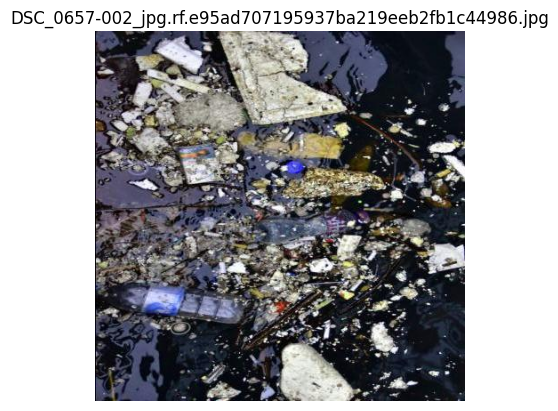

In [ ]:
# Charge et affiche l'image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(image_files[0])
plt.show()


In [8]:
#Relier la première image au premier label
#Pas sûr d'utiliser la bonne fonction, est ce que je créer un path pour les deux ou est ce que je les relie entre eux ?
image_path = os.path.join(image_dir, image_files[0])
image_path

'raw_data/train/images/DSC_0657-002_jpg.rf.e95ad707195937ba219eeb2fb1c44986.jpg'